In [140]:
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix, csr_matrix
from scipy.spatial.distance import jaccard, cosine 

import pandas as pd

In [228]:
from keras.callbacks import EarlyStopping

In [141]:
from pathlib import Path
import tifffile as tiff

In [142]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [143]:
import tensorflow as tf
print(tf.config.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Descritpion of problem:
Data is 96 by 96 by 3 images of body scans either containing metastatic caner or not. There are 220k images in the test data with a label 0 if negative and 1 if positive. I missed this when I first stated but the label is only within the center 32 by 32 by 3 area.

EDA:
I viewed a couple training samples images that were positve and some that were negative.  I also looked at different histograms of their intesity of color to see if there were trends that made some negative and some positive. The big data cleaning was when i implemented the keras model of taking the center 32 by 32.   I added some padding to not lose the filtering on the borders. My plan is to run a keras model that has multiple convulutional layers (filtering,pooling,normalization) to then fit agianst the train to improve AUC ROC.

Architecture: I first wanted to load in the shape of the correct shape of the whole data that we have. I then wanted to scale the 3 colors to between 0 and 1 by dividing by 255. Since the true label is found through the center 32 x 32 I chose to crop through the center with padding of 2 on all the sides. I tried different amounts of layers, filter sizes and batches, and dropouts. The more parameters the slower the model. I also experiemented with the learning rate trying to converge without have to run too many epochs.

Results and analysis.

After trying many different iterations i was able to move my score up from 70 into the low 80s.  I ran a early stopping to try and maximize the AUC to know when to stop. I experiemented with different # layers and had more success when parameter were not enormous as it slowed down the fit. I also experemented with different learning rates to increae convergence. The largest value add came from reducing paramenters and the intial filtering of the center.

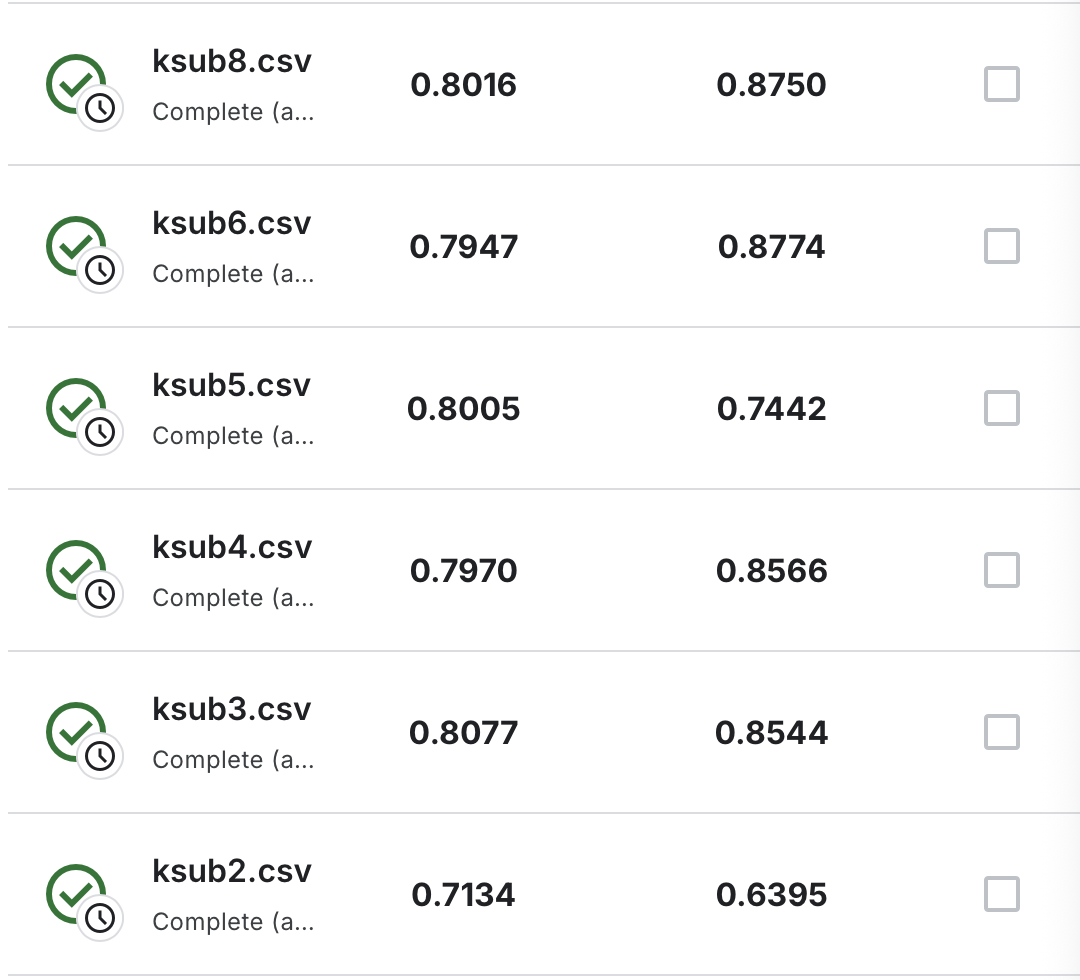

Conclusion:
I learned that it is important to understand to fully undertand the problem and the data before trying to write code to solve it. I learned that it is important to not have too many parameters and too small of batch size as it can take the model too long to converage.  I learned that it is good to use early stopping on model fits as this allows you to run model and walk away.  I spent a long time trying to rerun models with different parameters.  I think using a validation set(portion of the training data to test on would help me understand when the model is properly converged and fit as a faster way to get better perfomance.

In [144]:
df= pd.read_csv("/Users/kevinwalker/Downloads/histopathologic-cancer-detection/train_labels.csv")

In [145]:
train_folder = "/Users/kevinwalker/Downloads/histopathologic-cancer-detection/train"

In [146]:
train_files = sorted([*Path(train_folder).glob("*.tif"),*Path(train_folder).glob("*tiff")])
#print(train_files[0:10])


In [147]:
train_images =[tiff.imread(str(p)) for p in train_files]

EDA images of postive and negative images

postive examples


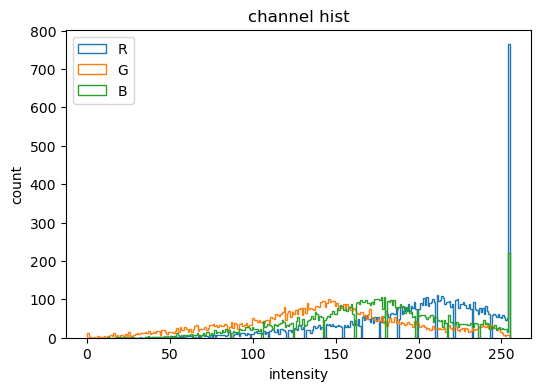

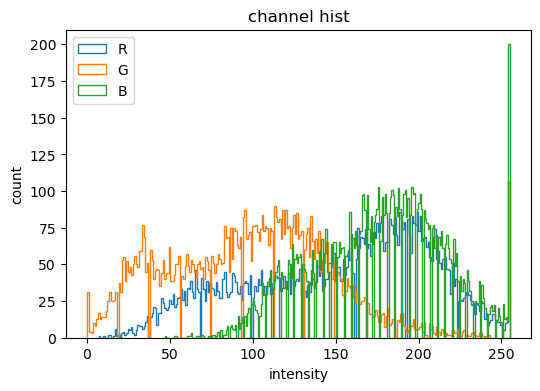

In [226]:
print("postive examples")
img1 = train_images[0]
dimen= [img1[...,0].ravel(),img1[...,1].ravel(),img1[...,2].ravel()]

plt.figure(figsize=(6,4))
for data,name, col, in zip(dimen,['R',"G","B"],['r','g','b']):
    plt.hist(data,bins=256,histtype='step', label=name)
plt.xlabel("intensity");plt.ylabel('count');plt.title('channel hist')
plt.legend()
plt.show()

img2 = train_images[4]
dimen= [img2[...,0].ravel(),img2[...,1].ravel(),img2[...,2].ravel()]

plt.figure(figsize=(6,4))
for data,name, col, in zip(dimen,['R',"G","B"],['r','g','b']):
    plt.hist(data,bins=256,histtype='step', label=name)
plt.xlabel("intensity");plt.ylabel('count');plt.title('channel hist')
plt.legend()
plt.show()

negative examples


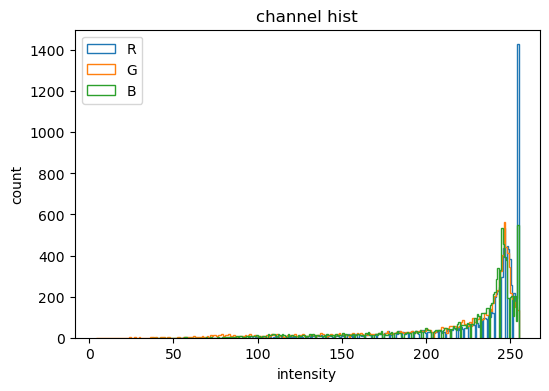

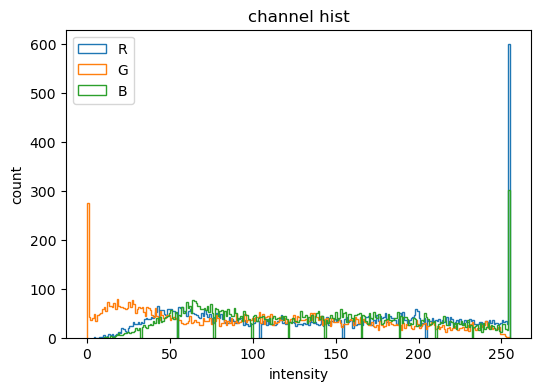

In [225]:
print("negative examples")
img1 = train_images[1]
dimen= [img1[...,0].ravel(),img1[...,1].ravel(),img1[...,2].ravel()]

plt.figure(figsize=(6,4))
for data,name, col, in zip(dimen,['R',"G","B"],['r','g','b']):
    plt.hist(data,bins=256,histtype='step', label=name)
plt.xlabel("intensity");plt.ylabel('count');plt.title('channel hist')
plt.legend()
plt.show()

img2 = train_images[2]
dimen= [img2[...,0].ravel(),img2[...,1].ravel(),img2[...,2].ravel()]

plt.figure(figsize=(6,4))
for data,name, col, in zip(dimen,['R',"G","B"],['r','g','b']):
    plt.hist(data,bins=256,histtype='step', label=name)
plt.xlabel("intensity");plt.ylabel('count');plt.title('channel hist')
plt.legend()
plt.show()

AxesImage(shape=(96, 96, 3)) positive


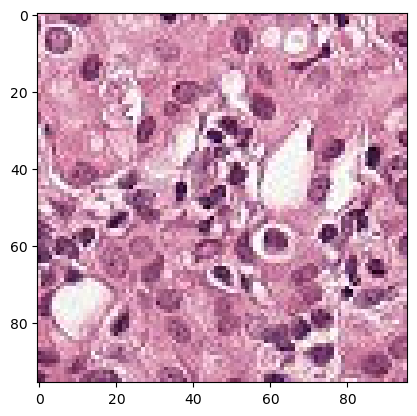

In [216]:
print(plt.imshow(train_images[0]),"positive")

AxesImage(shape=(96, 96, 3)) negative


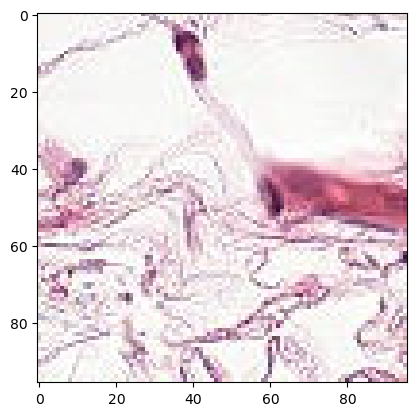

In [217]:
print(plt.imshow(train_images[1]),"negative")

AxesImage(shape=(96, 96, 3)) negative


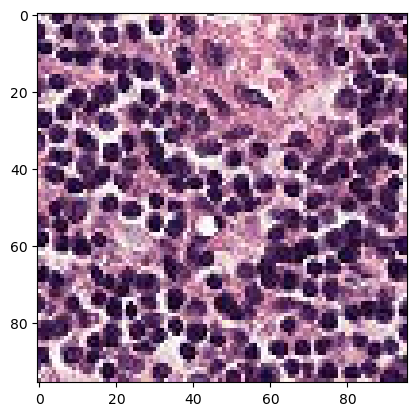

In [219]:
print(plt.imshow(train_images[2]),"negative")

AxesImage(shape=(96, 96, 3)) positve


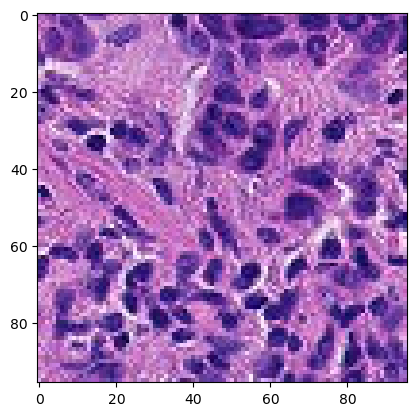

In [221]:
print(plt.imshow(train_images[4]),"positve")

In [157]:
df1 = df.sort_values('id',ascending=True)
print(df1.head())

                                              id  label
151577  00001b2b5609af42ab0ab276dd4cd41c3e7745b5      1
16166   000020de2aa6193f4c160e398a8edea95b1da598      0
87832   00004aab08381d25d315384d646f5ce413ea24b1      0
69359   0000d563d5cfafc4e68acb7c9829258a298d9b6a      0
128953  0000da768d06b879e5754c43e2298ce48726f722      1


In [158]:
Y=df1['label']

print(Y[:10])

151577    1
16166     0
87832     0
69359     0
128953    1
95060     0
134354    0
52564     0
78234     0
90027     1
Name: label, dtype: int64


In [159]:
print(len(train_images), train_images[1].shape,train_images[0].dtype)

220025 (96, 96, 3) uint8


In [160]:
test_folder = "/Users/kevinwalker/Downloads/histopathologic-cancer-detection/test"

In [161]:
test_files = sorted([*Path(test_folder).glob("*.tif"),*Path(test_folder).glob("*tiff")])

In [162]:
test_images =[tiff.imread(str(p)) for p in test_files]

In [163]:
print(len(test_images), test_images[0].shape,test_images[0].dtype)

57458 (96, 96, 3) uint8


Data loaded above Keras CNN model string starts below

In [187]:
xin = keras.Input(shape=(96,96,3))

In [188]:
x= layers.Rescaling(1/255.0)(xin)

In [189]:
x= layers.CenterCrop(32,32)(x)

In [190]:
x = layers.ZeroPadding2D(padding=2)(x)

In [191]:
x = layers.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu')(x)

In [192]:
x = layers.BatchNormalization()(x)

In [193]:
x = layers.Conv2D(filters=64,kernel_size=3,padding='same',activation='relu')(x)

In [194]:
x.shape

(None, 36, 36, 64)

In [195]:
x=layers.BatchNormalization()(x)

In [196]:
x= layers.Dropout(.80)(x)

In [197]:
x =layers.GlobalAveragePooling2D()(x)

In [198]:
x.shape

(None, 64)

In [199]:
xout = layers.Dense(1,activation ='sigmoid')(x)

In [200]:
CNNmodel= keras.Model(inputs=xin,outputs=xout)

In [201]:
CNNmodel.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',keras.metrics.AUC])

In [202]:
X= np.stack(train_images, axis=0)
print(X.shape)

(220025, 96, 96, 3)


In [203]:
X_test= np.stack(test_images, axis=0)
print(X_test.shape)

(57458, 96, 96, 3)


In [204]:
CNNmodel.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ center_crop_4 (CenterCrop)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_8                │ (None, 36, 36, 3)      │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 36, 36, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 36, 36, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 36, 36, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 36, 36, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,841 (77.50 KB)

 Trainable params: 19,649 (76.75 KB)

 Non-trainable params: 192 (768.00 B)

In [232]:
print(train_images[0].shape)

(96, 96, 3)


In [231]:
CNNmodel.fit(x=X,y=Y,epochs=30, class_weight ={0:.833,1:1.25},batch_size =75,callbacks= EarlyStopping(monitor = 'auc_3',patience = 3, mode ='max',restore_best_weights= True))

Epoch 1/30
2934/2934 ━━━━━━━━━━━━━━━━━━━━ 83s 28ms/step - accuracy: 0.5749 - auc_3: 0.6538 - loss: 0.6245 
Epoch 2/30
2934/2934 ━━━━━━━━━━━━━━━━━━━━ 82s 28ms/step - accuracy: 0.5736 - auc_3: 0.6538 - loss: 0.6239 
Epoch 3/30
2934/2934 ━━━━━━━━━━━━━━━━━━━━ 84s 29ms/step - accuracy: 0.5752 - auc_3: 0.6555 - loss: 0.6227 
Epoch 4/30
2934/2934 ━━━━━━━━━━━━━━━━━━━━ 85s 29ms/step - accuracy: 0.5755 - auc_3: 0.6574 - loss: 0.6220 
Epoch 5/30
2934/2934 ━━━━━━━━━━━━━━━━━━━━ 85s 29ms/step - accuracy: 0.5763 - auc_3: 0.6560 - loss: 0.6219 
Epoch 6/30
2934/2934 ━━━━━━━━━━━━━━━━━━━━ 86s 29ms/step - accuracy: 0.5759 - auc_3: 0.6571 - loss: 0.6214 
Epoch 7/30
2934/2934 ━━━━━━━━━━━━━━━━━━━━ 87s 30ms/step - accuracy: 0.5776 - auc_3: 0.6589 - loss: 0.6197 
Epoch 8/30
2934/2934 ━━━━━━━━━━━━━━━━━━━━ 87s 30ms/step - accuracy: 0.5779 - auc_3: 0.6593 - loss: 0.6189 
Epoch 9/30
2934/2934 ━━━━━━━━━━━━━━━━━━━━ 89s 30ms/step - accuracy: 0.5786 - auc_3: 0.6602 - loss: 0.6179 
Epoch 10/30
2934/2934 ━━━━━━━━━━━━━━━

In [240]:
#model stopped when 3 iteration produced no better area under the curve
yhat= CNNmodel.predict(x=X_test)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [234]:
#switching yhat to label to print to csv and submit
label =yhat

In [239]:
print(test_files[0], label)

/Users/kevinwalker/Downloads/histopathologic-cancer-detection/test/00006537328c33e284c973d7b39d340809f7271b.tif [[0.8943488 ]
 [0.81481457]
 [0.55548114]
 ...
 [0.0125193 ]
 [0.9782559 ]
 [0.04833158]]


In [237]:
idstest = [Path(p).stem for p in test_files]
result =pd.DataFrame({'id':idstest,'label':np.ravel(label)})

In [238]:
result.to_csv('ksub10.csv' ,index=False)